In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from pathlib import Path
import os
import sys
try:
    # Only on works on Google Colab
    from google.colab import files
    %tensorflow_version 2.x
    os.chdir('..')
    
    # Configure kaggle if necessary
    if not (Path.home() / '.kaggle').is_dir():
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json
    
    !pip install git+https://github.com/SachsLab/indl.git
    
    if Path.cwd().stem == 'MonkeyPFCSaccadeStudies':
        os.chdir(Path.cwd().parent)
    
    if not (Path.cwd() / 'MonkeyPFCSaccadeStudies').is_dir():
        !git clone --single-branch --recursive https://github.com/SachsLab/MonkeyPFCSaccadeStudies.git
        sys.path.append(str(Path.cwd() / 'MonkeyPFCSaccadeStudies'))
    
    os.chdir('MonkeyPFCSaccadeStudies')
        
    !pip install -q kaggle
    
    # Latest version of SKLearn
    !pip install -U scikit-learn
    
    IN_COLAB = True
    
except ModuleNotFoundError:    
    # chdir to MonkeyPFCSaccadeStudies
    if Path.cwd().stem == 'Analysis':
        os.chdir(Path.cwd().parent.parent)
        
    # Add indl repository to path.
    # Eventually this should already be pip installed, but it's still under heavy development so this is easier for now.
    check_dir = Path.cwd()
    while not (check_dir / 'Tools').is_dir():
        check_dir = check_dir / '..'
    indl_path = check_dir / 'Tools' / 'Neurophys' / 'indl'
    sys.path.append(str(indl_path))
    
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')
    
    IN_COLAB = False

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

KeyboardInterrupt: 

In [ ]:
# # Additional imports
# import tensorflow as tf
# import numpy as np
# import random
# import matplotlib.pyplot as plt
# from indl.display import turbo_cmap

In [2]:
from pathlib import Path
import sys
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from tensorflow.keras import Sequential


# from indl.display import turbo_cmap
from sklearn.model_selection import train_test_split
import os

if Path.cwd().stem == 'Analysis':
    os.chdir(Path.cwd().parent.parent)
data_path = Path.cwd() / 'StudyLocationRule'/ 'Data' / 'Preprocessed'
if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")
from misc.misc import sess_infos, load_macaque_pfc, dec_from_enc

load_kwargs = {
    'valid_outcomes': (0,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.25),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

load_kwargs_error = {
    'valid_outcomes': (9,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.25),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

load_kwargs_all = {
    'valid_outcomes': (0,9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.25),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

Data directory found. Skipping download.


In [3]:
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.figsize': (6.4, 6.4)
})

In [13]:
# if IN_COLAB:
#     data_path = Path.cwd() / 'data' / 'monkey_pfc' / 'converted'
# else:
#     data_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed'

# if not (data_path).is_dir():
#     !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
#     print("Finished downloading and extracting data.")
# else:
#     print("Data directory found. Skipping download.")

Data directory found. Skipping download.


In [4]:
# from misc.misc import sess_infos, load_macaque_pfc, dec_from_enc

# load_kwargs = {
#     'valid_outcomes': (0,),  # Use (0, 9) to include trials with incorrect behaviour
#     'zscore': True,
#     'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
#     'time_range': (-np.inf, 1.45),
#     'verbose': False,
#     'y_type': 'sacClass',
#     'samples_last': True    
#     #     'resample_X': 20
# }

In [10]:
test_sess_ix = 1
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
print(f"\nImporting session {sess_id}")
X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
classes, _y = np.unique(Y_class, return_inverse=True)
# Y_class = tf.keras.utils.to_categorical(Y_class, num_classes=8)
X_rates.shape


Importing session sra3_1_j_050_00+


(285, 36, 186)

In [11]:
from tensorflow.keras.models import load_model
model = load_model("r2c_lstm_sra3_1_j_050_00+_split1.h5")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 186)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 36, 186, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 167, 8)        168       
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 167, 8)        32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 167, 8)         296       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 167, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 1, 167, 8)         0     

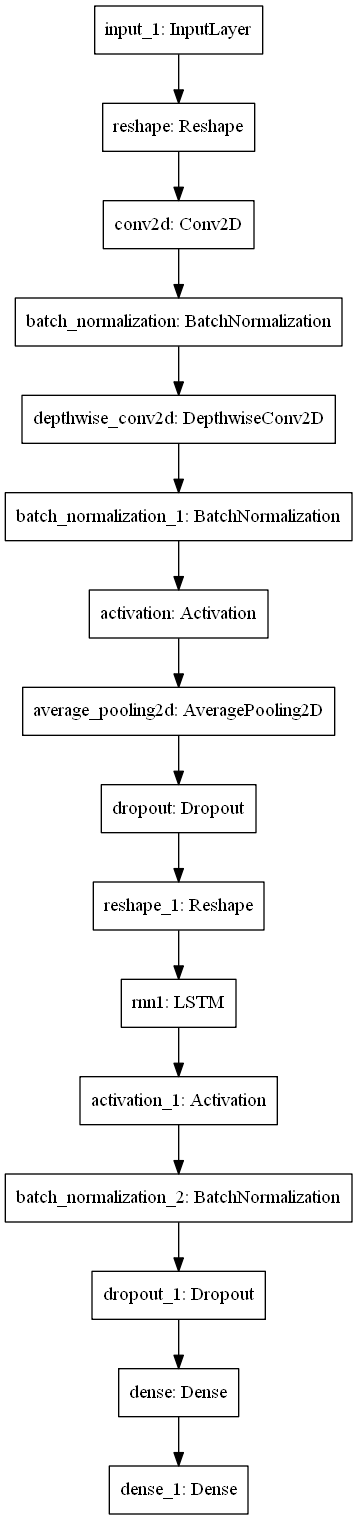

In [17]:
tf.keras.utils.plot_model(model)

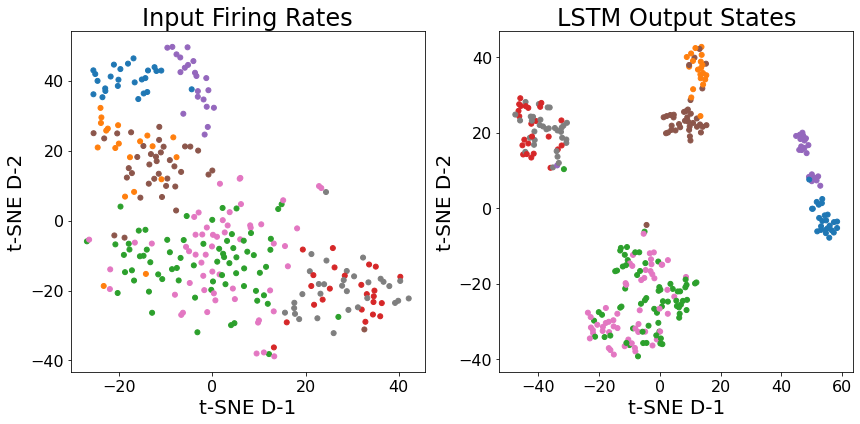

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(10)))
class_colors = np.array([next(colour_codes) for _ in range(10)])  # b, o, g, r
# class_colors = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])

TEST_PERPLEXITY = [10]
X = X_rates

fig = plt.figure(figsize=(18, 6))
def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    plt.xlabel('t-SNE D-1')
    plt.ylabel('t-SNE D-2')
    plt.title(title)
    ax = plt.gca()

# First plot a t-SNE on the input data. Precede TSNE with a PCA.
pca = PCA(n_components=50)
pca_values = pca.fit_transform(X.reshape([-1, np.prod(X.shape[1:])]))
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY[-1])
tsne_values = tsne_model.fit_transform(pca_values)
plt.subplot(1, 3, 1)
plot_tsne(tsne_values, _y.ravel(), TEST_PERPLEXITY[-1], title='Input Firing Rates')

# Let's create a version of our CNN model that goes from input all the way to the 200-D flatten layer
output_layer = -5
tbs = 30  # tsne batch size
truncated_model = tf.keras.Model(model.input, model.layers[output_layer].output)
flattened_output = []
for start_ix in range(0, X.shape[0], tbs):
#     flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, MAX_OFFSET:, :].astype(np.float32)[:, :, :, None]))
    flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, :, :].astype(np.float32)))
flattened_output = tf.concat(flattened_output, 0)
tf.keras.backend.clear_session()

for p_ix, perplexity in enumerate(TEST_PERPLEXITY):
    # Initialize and fit our TSNE
    tsne_model = TSNE(n_components=2, perplexity=perplexity)
    tsne_values = tsne_model.fit_transform(flattened_output)
    
    plt.subplot(1, 3, p_ix + 2)
    plot_tsne(tsne_values, _y.ravel(), perplexity, title='LSTM Output States')

plt.tight_layout()
plt.savefig("decode.svg")

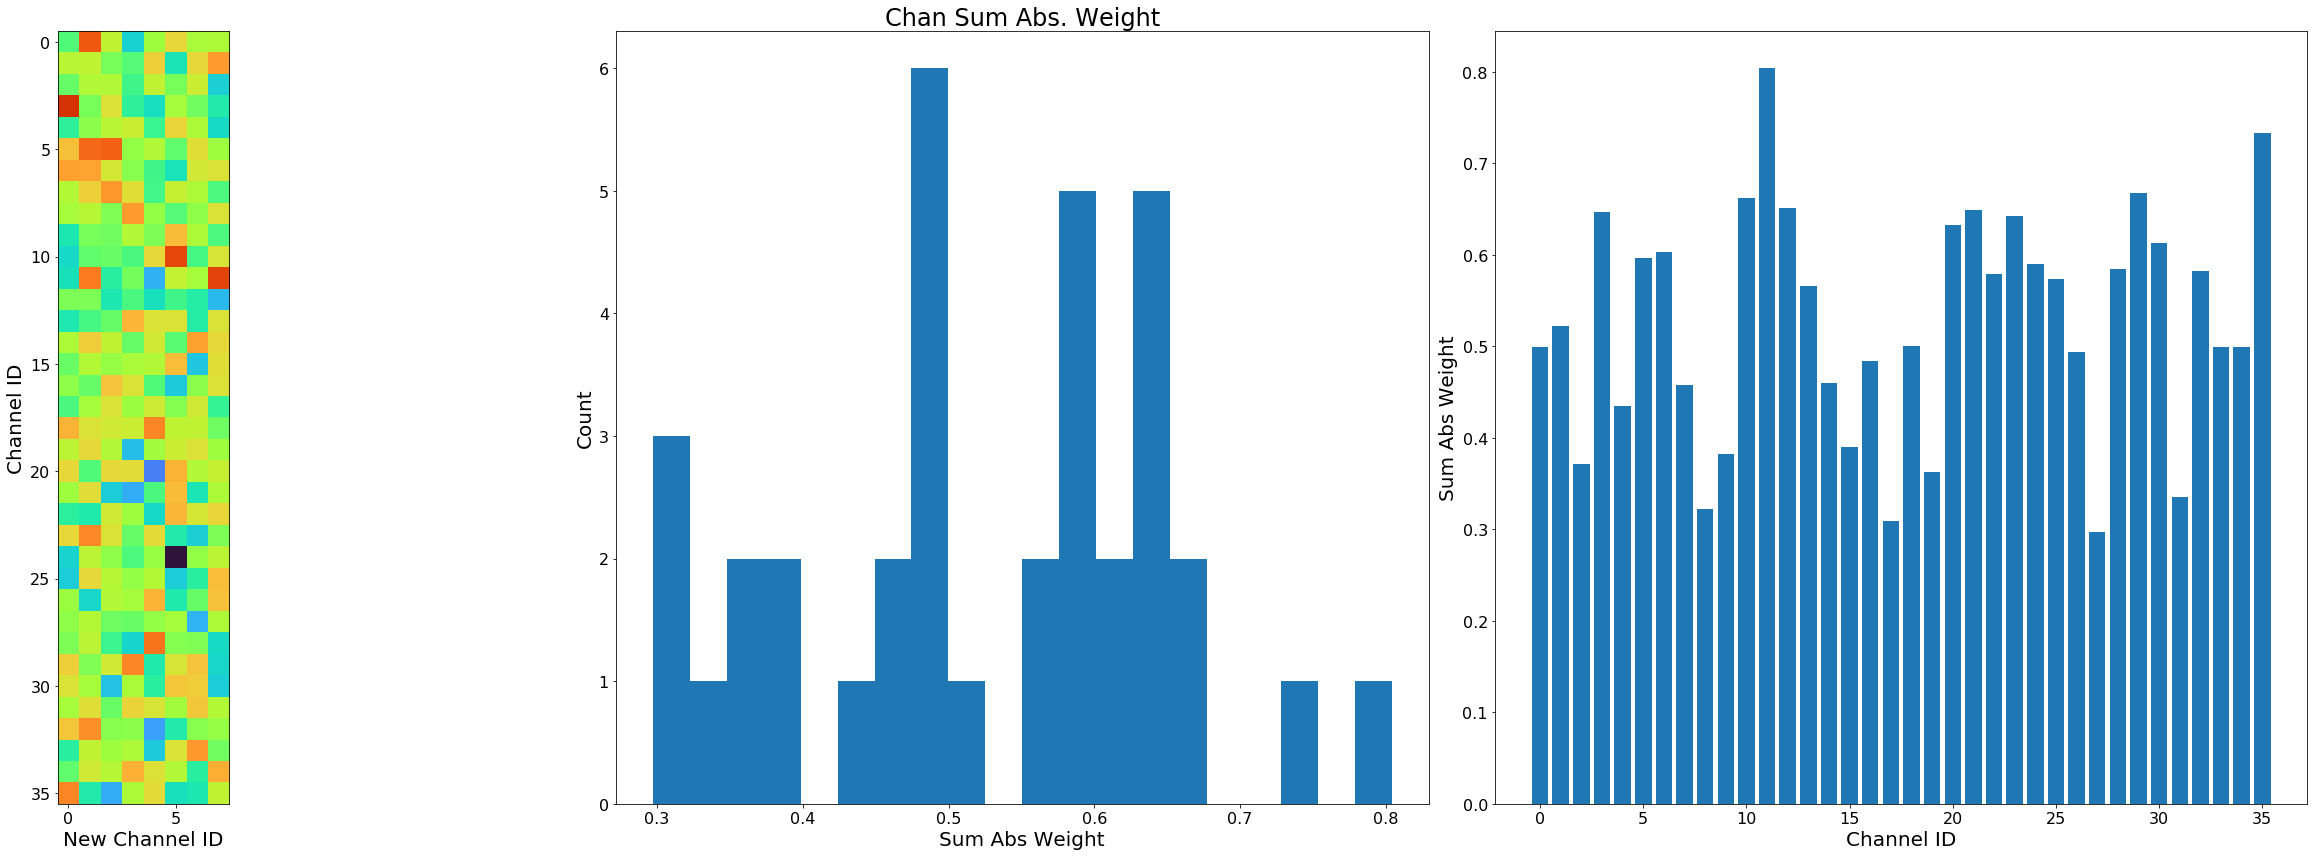

Top channels: ['ch11' 'ch32' 'ch29' 'ch11']
Bottom channels: ['ch29' 'ch9' 'ch14' 'ch27']


In [19]:
LAYER_IX = 4
spatial_filter = np.squeeze(model.layers[LAYER_IX].get_weights()[0])
D = spatial_filter.shape[-1]
sp_cols = int(np.ceil(np.sqrt(D + 2)))
sp_rows = int(np.ceil((D + 2) / sp_cols))
vmax=abs(spatial_filter).max()
vmin=-abs(spatial_filter).max()
fig = plt.figure(figsize=(36, 12))
# for depth_ix in range(D):
#     plt.subplot(sp_rows, sp_cols, depth_ix + 1)
#     plt.imshow(spatial_filter[:, depth_ix], vmax=vmax, vmin=vmin, cmap=turbo_cmap)
#     plt.title('Spatial Filter Set {}'.format(depth_ix))
#     plt.xlabel('Temporal Filter')
#     plt.ylabel('Input Channel')
# # plt.colorbar()
plt.subplot(1, 3, 1)
plt.imshow(spatial_filter, vmax=vmax, vmin=vmin, cmap=turbo_cmap)
plt.xlabel('New Channel ID')
plt.ylabel('Channel ID')

sum_abs_weight = np.sum(np.abs(spatial_filter), axis=1)
plt.subplot(1, 3, 2)
plt.hist(sum_abs_weight, 20)
plt.xlabel('Sum Abs Weight')
plt.ylabel('Count')
plt.title('Chan Sum Abs. Weight')

plt.subplot(1, 3, 3)
plt.bar(np.arange(spatial_filter.shape[0]), sum_abs_weight)
plt.xlabel('Channel ID')
plt.ylabel('Sum Abs Weight')

plt.tight_layout()
plt.show()

ch_ids = np.argsort(sum_abs_weight)[::-1]  # channel_ids sorted by weight, descending
print("Top channels: {}".format(ax_info['channel_names'][ch_ids][:4]))
print("Bottom channels: {}".format(ax_info['channel_names'][ch_ids][-4:]))

In [20]:
layer_ix = 14  # 10: separable_conv2d
truncated_model = tf.keras.Model(model.input, model.layers[layer_ix].output)

In [21]:
from tensorflow.keras import backend as K

def get_saliency(_model, _X, tr_id):
    
    # Convert the input data _X to tf data.
    _input = tf.convert_to_tensor(_X[tr_id].astype(np.float32)[None, :, :])
    
    # Do we use the full model (incl SoftMax) or the truncated model as above?
    # If truncated model then we need a different loss function.
    
    # We will calculate the saliency for each output class
    _n_classes = _model.layers[-1].output.shape[-1]
    losses_grads = []
    for y_ix in range(_n_classes):
        with tf.GradientTape() as tape:
            tape.watch(_input)
            class_proba = _model(_input)
            loss_value = K.sparse_categorical_crossentropy(y_ix, class_proba)
        grads = tape.gradient(loss_value, _input)
        # Normalize gradients
        grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
#         print(f'grads: {grads.shape} & loss_value: {loss_value.numpy()[0].shape}')
        # Save output
        losses_grads.append((loss_value.numpy()[0], np.squeeze(grads)))
    return losses_grads

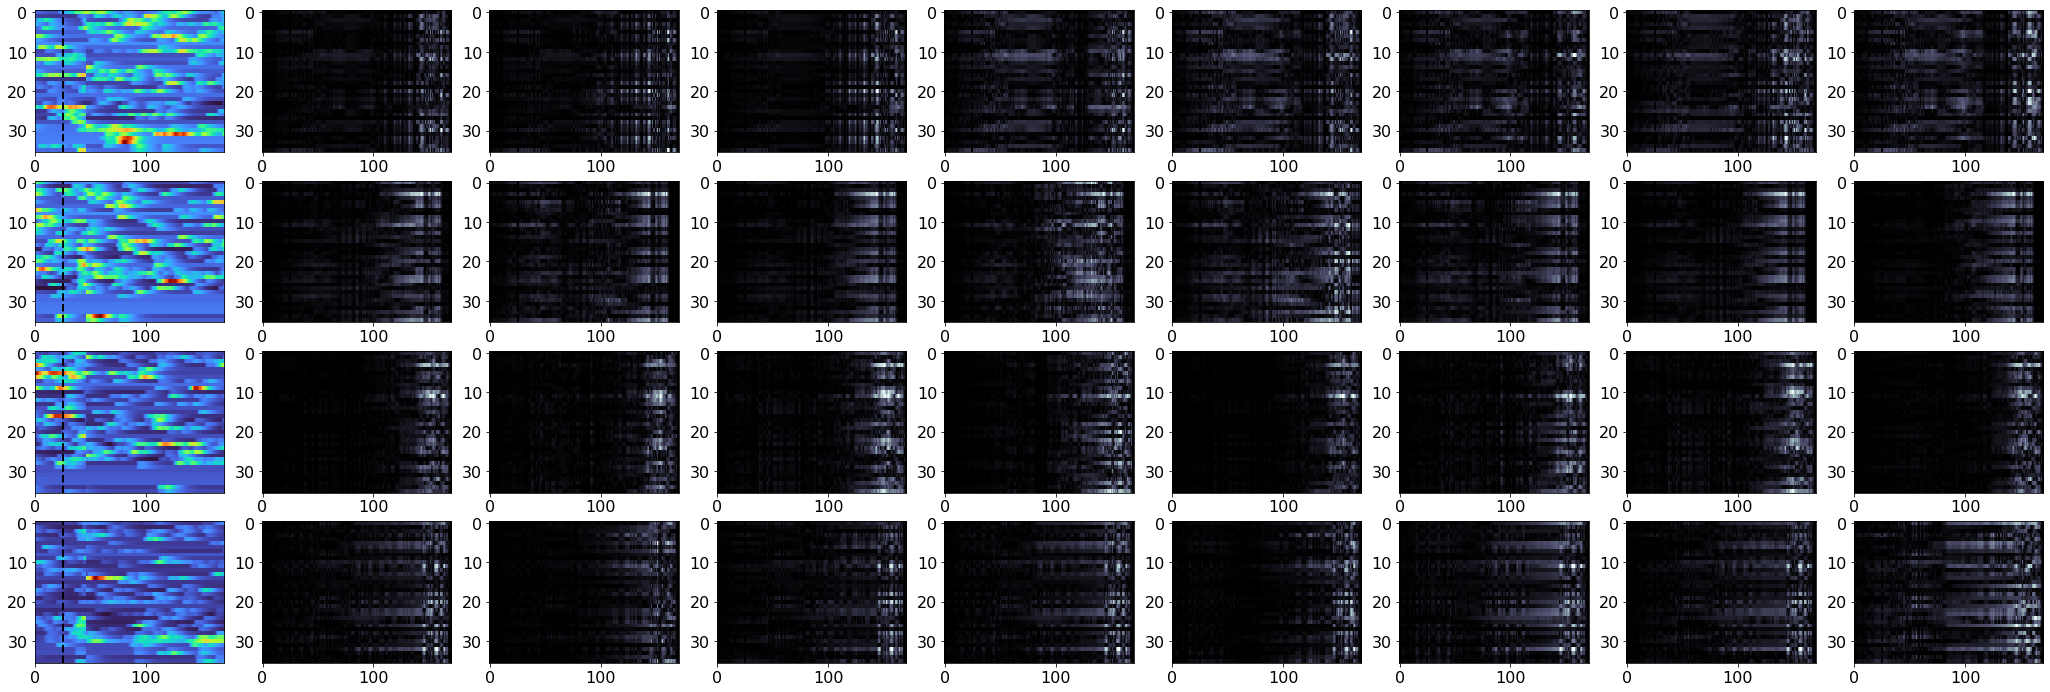

In [22]:
N_PLOT_SALIENCY = 4
t_vec = ax_info['timestamps']

trial_ids = np.random.permutation(X.shape[0])[:N_PLOT_SALIENCY]

fig, ax = plt.subplots(nrows=N_PLOT_SALIENCY, ncols=9, sharex=True, sharey=True, figsize=(36, 12))
# fig.text('Time Samples', ha='center')
# fig.text('Channels', va='center', rotation='vertical')
x0_ix = np.argmin(np.abs(t_vec))

for row_ix, tr_id in enumerate(trial_ids):
    l_g = get_saliency(model, X, tr_id)
    
    plt.subplot(N_PLOT_SALIENCY, 9, 9*row_ix + 1)
    plt.imshow(X[tr_id], aspect='auto', cmap=turbo_cmap)
    plt.axvline(x0_ix, color='k', linestyle='--')
#     plt.title('Input Trial {}'.format(tr_id))
    
    for y_ix in range(8):
        plt.subplot(N_PLOT_SALIENCY, 9, 9*row_ix + 2 + y_ix)
        plt.imshow(np.abs(l_g[y_ix][1]), aspect='auto', cmap='bone')
        plt.axvline(x0_ix, color='k', linestyle='--')
#         plt.title("{:.3f}".format(l_g[y_ix][0]))

In [23]:
l_g[0][1].shape

(36, 171)

In [24]:
pred_y = model.predict(X)

In [26]:
print(np.argmax(pred_y, axis=1)[36]) #27
print(_y[36])

7
3


In [27]:
trial_ids = np.array([27, 36, 144, 240])

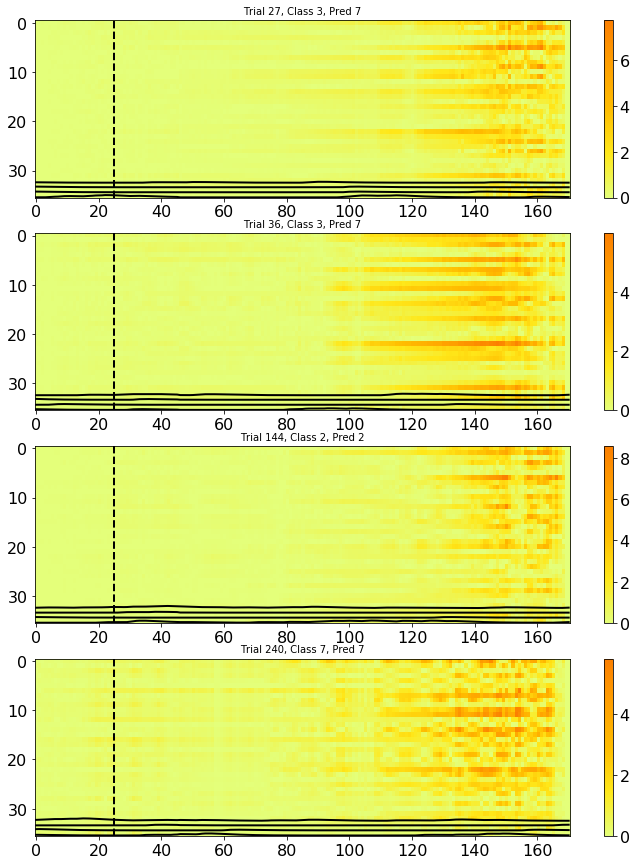

In [28]:
fig = plt.figure(figsize=(12, 15))
x0_ix = np.argmin(np.abs(t_vec))
y_offset = -1

for row_ix, tr_id in enumerate(trial_ids):
    l_g = get_saliency(model, X, tr_id)
    plt.subplot(N_PLOT_SALIENCY, 1, row_ix + 1)
    
    y_ix = np.argmin([_[0] for _ in l_g])
    g = l_g[y_ix][1][ch_ids, :]
    plt.imshow(np.abs(g), aspect='auto', cmap='Wistia')
    
    dat = X[tr_id, ch_ids, :]
    dat -= np.min(dat)
    dat /= np.max(dat)
    dat = 0.5 - dat + np.arange(36)[::-1][:, None]
    for ch_ix in range(4):
        plt.plot(dat[ch_ix], 'k')
        
    plt.title("Trial {}, Class {}, Pred {}".format(tr_id, _y[tr_id], y_ix), fontsize=10)
    plt.axvline(x0_ix, color='k', linestyle='--')
    plt.colorbar()

In [29]:
def get_losses_for_class(test_class, correct_only=False):
    classes, y = np.unique(_y, return_inverse=True)
    trial_ids = np.where(y == classes.tolist().index(test_class))[0]
    losses_grads = []
    for tr_id in trial_ids:
        input_data = tf.convert_to_tensor(X[tr_id].astype(np.float32)[None, :, :])
        with tf.GradientTape() as tape:
            tape.watch(input_data)
            class_proba = model(input_data)
            loss_value = K.sparse_categorical_crossentropy(y[tr_id], class_proba)
        grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
        # Normalize gradients
        grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
        if (not correct_only) or (y[tr_id] == np.argmax(class_proba)):
            losses_grads.append((loss_value.numpy()[0], np.squeeze(grads)))
    return losses_grads

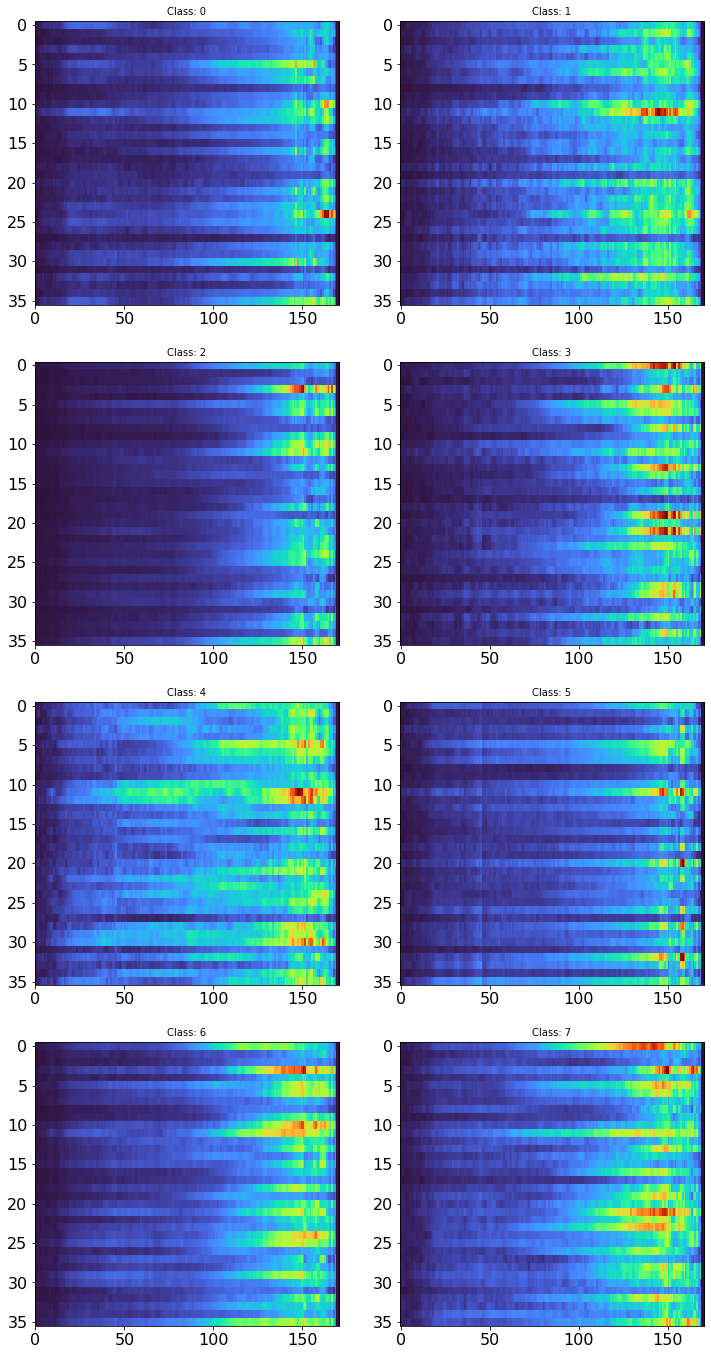

In [30]:
fig = plt.figure(figsize=(12, 24))
for plot_ix, class_name in enumerate([0,1,2,3,4,5,6,7]):
    l_g = get_losses_for_class(class_name, correct_only=True)
    _sal = np.mean(np.abs(np.stack([_[1] for _ in l_g], axis=0)), axis=0)
    
    plt.subplot(4, 2, plot_ix + 1)
    plt.imshow(_sal, aspect='auto', cmap=turbo_cmap)
    plt.title(f'Class: {class_name}', fontsize=10)

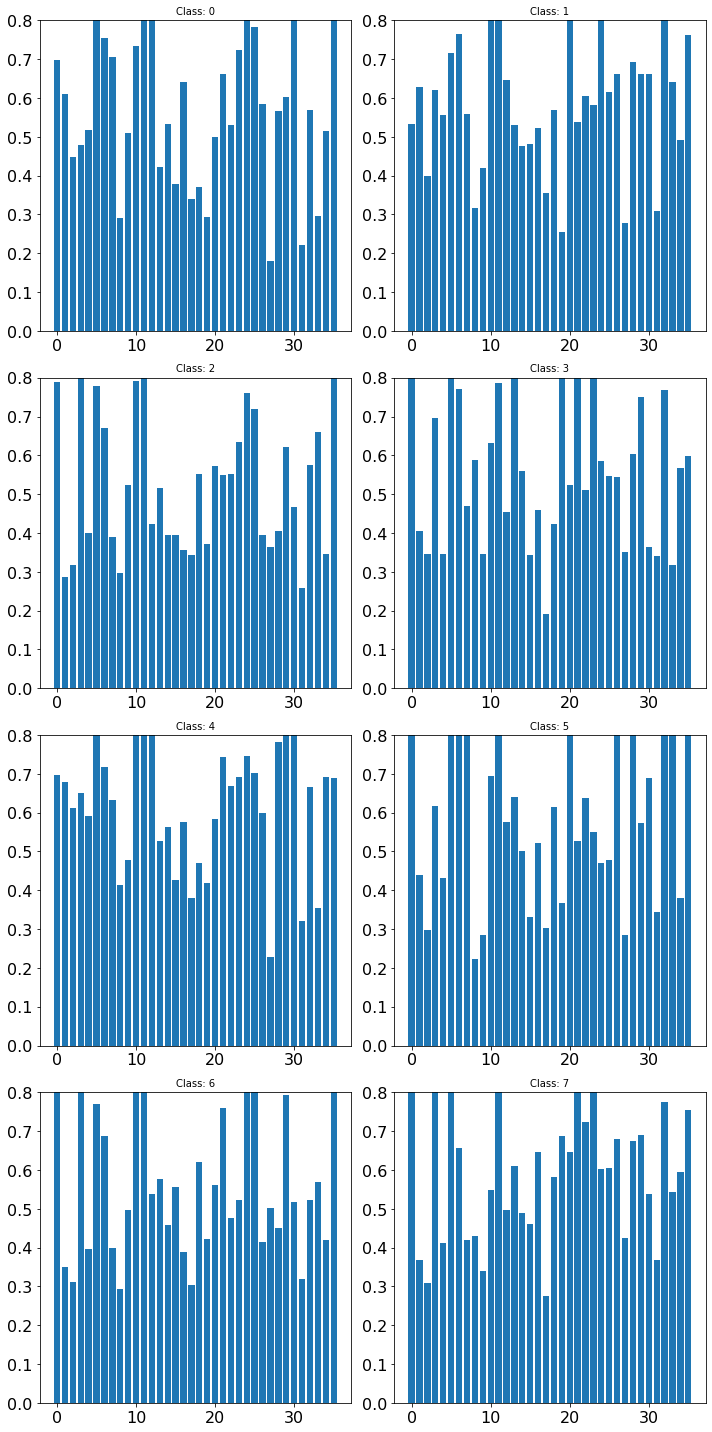

In [31]:
_width = 0.3
fig = plt.figure(figsize=(10, 20))
for plot_ix, class_name in enumerate([0,1,2,3,4,5,6,7]):
    l_g = get_losses_for_class(class_name, correct_only=True)
    _sal = np.mean(np.mean(np.abs(np.stack([_[1] for _ in l_g], axis=0)), axis=0), axis=-1)
#     plt.bar(np.arange(len(_sal)) + plot_ix*_width, _sal, _width, label=class_name)
    plt.subplot(4, 2, plot_ix + 1)
    plt.bar(np.arange(len(_sal)), _sal)
    plt.ylim([0, 0.8])
    plt.title(f'Class: {class_name}', fontsize=10)
plt.tight_layout()

### Fixed Point Analysis

In [32]:
output_layer = 7
model_factors = tf.keras.Model(model.input, model.layers[output_layer].output)
model_factors.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 171)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 36, 171, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 152, 8)        168       
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 152, 8)        32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 152, 8)         296       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 152, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 1, 152, 8)         0   

In [33]:
zero_input = np.zeros_like(X_rates)

In [34]:
factors = model_factors.predict(X_rates)
zero_factors = model_factors.predict(zero_input)

In [35]:
print(zero_factors.shape, factors.shape)

(285, 1, 30, 8) (285, 1, 30, 8)


In [36]:
zero_factors = np.reshape(zero_factors, (zero_factors.shape[0] * zero_factors.shape[1], zero_factors.shape[2]))
factors = np.reshape(factors, (factors.shape[0] * factors.shape[1], factors.shape[2]))
print(zero_factors.shape, factors.shape)

ValueError: cannot reshape array of size 68400 into shape (285,30)

### Getting the initial states

In [ ]:
from indl.model.recurrent import GenerativeRNN

N_UNITS = 64
# initial_state = np.empty((zero_input.shape[0]*zero_input.shape[1], N_UNITS))

gen_lstm_cell = GenerativeRNN(tf.keras.layers.LSTMCell(N_UNITS),
                              return_sequences=True, return_state=True)

# for t in range(zero_input.shape[0]):
#     for ts in range(zero_input.shape[1]):
#         _, state_h, _ = gen_lstm_cell(tf.reshape(zero_input[t, ts], (1, 1, zero_input.shape[2])))
#         initial_state[zero_input.shape[1]*t + ts] = state_h

### Generative LSTM Model

In [ ]:
inputs = tf.keras.layers.Input(shape = factors.shape[1:], dtype='float32')
output= gen_lstm_cell(inputs)
gen_lstm_model = tf.keras.Model(inputs, output)
gen_lstm_model.summary()


In [ ]:
# from tensorflow.keras import backend as K
# def reshape_batch(x):
#     return K.reshape(x, (-1, x.shape[2]))

# _y = model_factors.layers[-1].output
# _y = tf.keras.layers.Lambda(reshape_batch)(_y)
# output= gen_lstm_cell(_y)
# gen_lstm_model = tf.keras.Model(model_factors.input, output)
# gen_lstm_model.summary()

In [ ]:
lstm_weights = model.layers[8].get_weights()

gen_lstm_model.layers[2].set_weights(lstm_weights)

In [ ]:
print(lstm_weights[0].shape, lstm_weights[1].shape, lstm_weights[2].shape)

In [ ]:
initial_states = gen_lstm_model(zero_factors)[1]
print(initial_states.shape)

In [ ]:
initial_states.dtype

### Creating TF datasets

In [ ]:
# initial_state = tf.dtypes.cast(initial_state, tf.float32)

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((factors, initial_states))

ds_train = ds_train.batch(16, drop_remainder=True)

### Defining Loss and gradient

In [ ]:
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)[1]
    return 0.5 * tf.reduce_sum(tf.square(tf.subtract(y_, y)))



# l = loss(gen_lstm_model, factors, initial_state, training=False)


def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
# loss_value, grads = grad(gen_lstm_model, factors, initial_state)
# optimizer.apply_gradients(zip(grads, gen_lstm_model.trainable_variables))

### Training Loop

In [ ]:
# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

  # Training loop - using batches of 32
    for x, y in ds_train:
    # Optimize the model
        loss_value, grads = grad(gen_lstm_model, x, y)
        optimizer.apply_gradients(zip(grads, gen_lstm_model.trainable_variables))

    # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).

  # End epoch
    train_loss_results.append(epoch_loss_avg.result())

    if epoch % 20 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

In [ ]:
test = gen_lstm_model.predict(factors)[1]

In [ ]:
test = np.reshape(test, (X_rates.shape[0], int(test.shape[0]/X_rates.shape[0]), test.shape[1]))
test.shape

In [ ]:
plt.plot(test[0,:,0])

### Custom Model Fit

In [ ]:
mae_metric = tf.keras.metrics.MeanAbsoluteError(name="mae")
loss_tracker = tf.keras.metrics.Mean(name="loss")

class CustomModel(tf.keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)[1]  # Forward pass
            # Compute our own loss
            loss = 0.5 * tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss)
#         mae_metric.update_state(y, y_pred)
#         return {"loss": loss_tracker.result(), "mae": mae_metric.result()}
        return {"loss": loss_tracker.result()}


Custom Model

In [ ]:
# inputs = tf.keras.layers.Input(shape = factors.shape[1:], dtype='float32')
inputs = tf.keras.Input(shape=(32,))
output= tf.keras.layers.Dense(1)(inputs)
# output= gen_lstm_cell(inputs)
gen_lstm_custom_model = CustomModel(inputs, output)
gen_lstm_custom_model.summary()

In [ ]:
# We don't passs a loss or metrics here.
gen_lstm_custom_model.compile(optimizer="SGD")
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
gen_lstm_custom_model.fit(x, y, epochs=3)
# Just use `fit` as usual -- you can use callbacks, etc.
# gen_lstm_custom_model.fit(factors, initial_states, epochs=3)

In [ ]:
from sklearn.decomposition import PCA

NCOMP = 3
test_pca = np.empty((test.shape[0], test.shape[1], NCOMP))
for i in range(test.shape[0]):
    tmp = np.squeeze(test[i])
    pca = PCA(n_components=NCOMP)
    test_pca[i] = pca.fit_transform(tmp)

In [ ]:
fig = plt.figure()
ax = plt.axes(projection="3d")

z_line = np.squeeze(test_pca[1,:,2])
x_line = np.squeeze(test_pca[1,:,0])
y_line = np.squeeze(test_pca[1,:,1])
ax.plot3D(x_line, y_line, z_line)

In [ ]:
fig = plt.figure()
ax = plt.axes(projection="3d")

for i in range (10):
    z_line = np.squeeze(test_pca[i,:,2])
    x_line = np.squeeze(test_pca[i,:,0])
    y_line = np.squeeze(test_pca[i,:,1])
    ax.plot3D(x_line, y_line, z_line)